In [3]:
pip install wfdb


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Total waveform records found: 444

Reading record: E:\DL-BSP-SEMMM5\data\mimic3_waveform\p000020\3544749_0001
Record Name: 3544749_0001
Sampling Frequency: 125 Hz
Signal Names: ['II', 'AVF', 'ABP', 'PAP']
Number of Samples: 3811


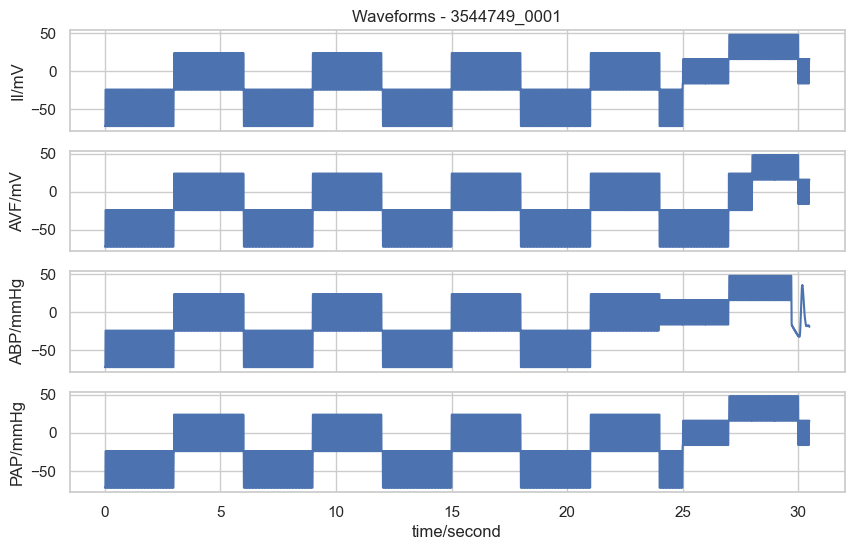

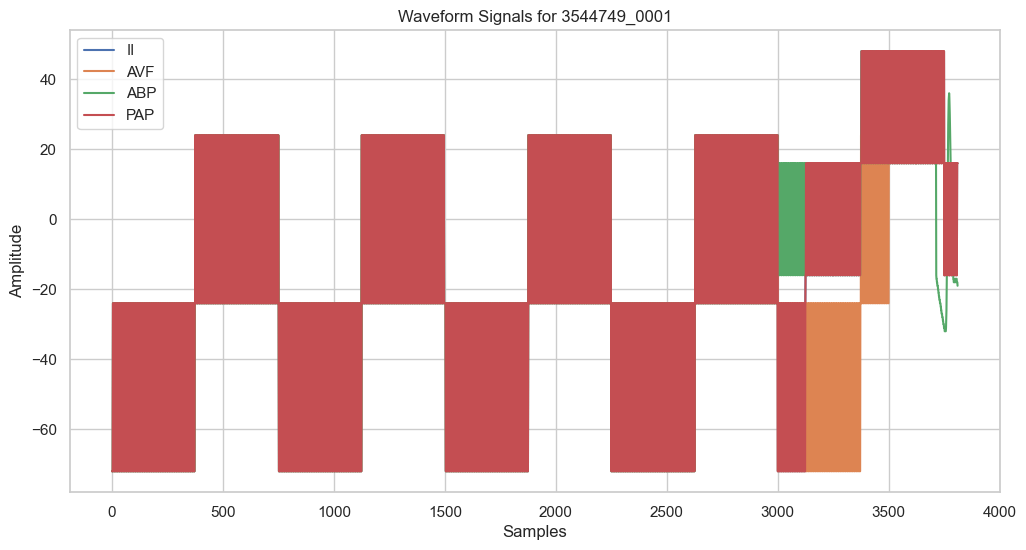

In [7]:
import wfdb
import os
import matplotlib.pyplot as plt

# Path to your MIMIC-III waveform data folder
base_dir = r"E:\DL-BSP-SEMMM5\data\mimic3_waveform"

# Collect all .hea files recursively
hea_files = []
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith(".hea"):
            hea_files.append(os.path.join(root, file))

# Check how many records found
print(f"Total waveform records found: {len(hea_files)}")

# If no records found, stop execution
if not hea_files:
    raise FileNotFoundError("No waveform records found. Check your path!")

# Pick the first waveform record for visualization
record_path = hea_files[0].replace(".hea", "")  # Remove .hea extension for wfdb
print(f"\nReading record: {record_path}")

# Read the waveform using wfdb
record = wfdb.rdrecord(record_path)

# Display basic info about the record
print(f"Record Name: {record.record_name}")
print(f"Sampling Frequency: {record.fs} Hz")
print(f"Signal Names: {record.sig_name}")
print(f"Number of Samples: {record.sig_len}")

# Plot all signals in the record
wfdb.plot_wfdb(record=record, title=f"Waveforms - {record.record_name}")

# Optionally, plot individual signals using matplotlib
plt.figure(figsize=(12, 6))
for i, sig in enumerate(record.p_signal.T):
    plt.plot(sig, label=record.sig_name[i])
plt.title(f"Waveform Signals for {record.record_name}")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


Total waveform records found: 444

Found ECG/PPG signals in record: 3544749_0001
Available signals: ['II', 'AVF', 'ABP', 'PAP']


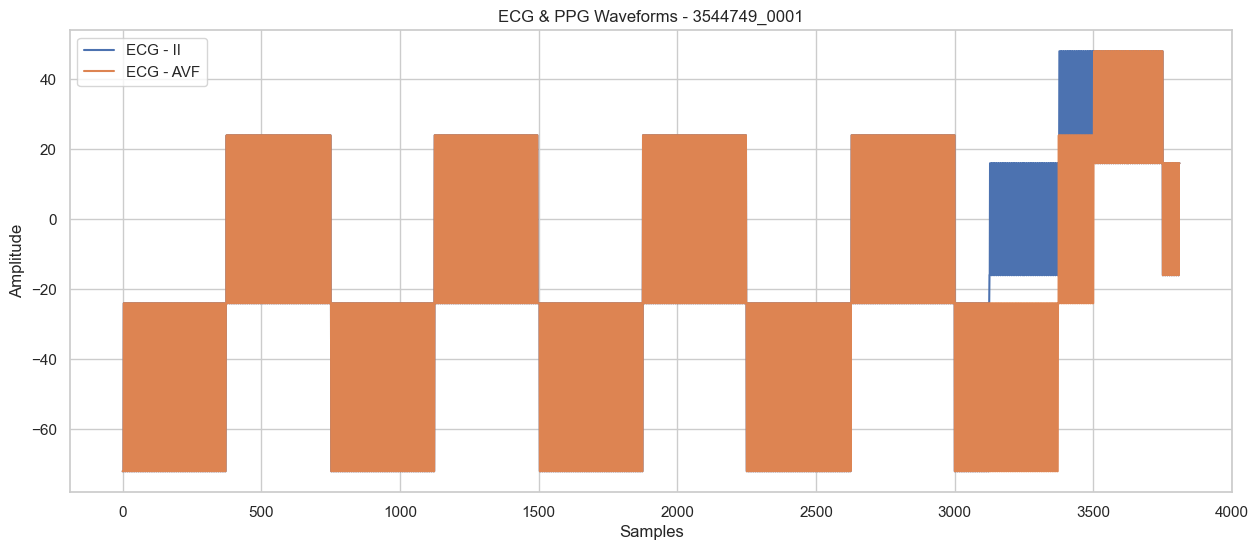

In [11]:
import wfdb
import os
import matplotlib.pyplot as plt

# Path to your MIMIC-III waveform data folder
base_dir = r"E:\DL-BSP-SEMMM5\data\mimic3_waveform"

# Recursively find all .hea files
hea_files = []
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith(".hea"):
            hea_files.append(os.path.join(root, file))

print(f"Total waveform records found: {len(hea_files)}")
if len(hea_files) == 0:
    raise FileNotFoundError("⚠️ No waveform files found!")

# Function to check if ECG or PPG signals exist
def has_ecg_or_ppg(record):
    ecg_keywords = ["ECG", "II", "I", "V1", "V2", "V3", "V4", "V5", "V6", "AVF", "AVL", "AVR"]
    ppg_keywords = ["PLETH", "PPG", "IRPLETH"]
    ecg_indices = [i for i, name in enumerate(record.sig_name) if any(k in name.upper() for k in ecg_keywords)]
    ppg_indices = [i for i, name in enumerate(record.sig_name) if any(k in name.upper() for k in ppg_keywords)]
    return ecg_indices, ppg_indices

# Iterate through all records until we find ECG or PPG signals
for idx, hea_path in enumerate(hea_files):
    record_path = hea_path[:-4]  # Remove ".hea"
    try:
        record = wfdb.rdrecord(record_path)
        ecg_indices, ppg_indices = has_ecg_or_ppg(record)

        # If we find ECG or PPG, plot them
        if ecg_indices or ppg_indices:
            print(f"\nFound ECG/PPG signals in record: {record.record_name}")
            print(f"Available signals: {record.sig_name}")

            plt.figure(figsize=(15, 6))

            # Plot ECG if available
            for i in ecg_indices:
                plt.plot(record.p_signal[:, i], label=f"ECG - {record.sig_name[i]}")

            # Plot PPG if available
            for i in ppg_indices:
                plt.plot(record.p_signal[:, i], label=f"PPG - {record.sig_name[i]}")

            plt.title(f"ECG & PPG Waveforms - {record.record_name}")
            plt.xlabel("Samples")
            plt.ylabel("Amplitude")
            plt.legend()
            plt.show()
            break  # Stop after finding the first valid record

    except Exception as e:
        print(f"⚠️ Error reading {record_path}: {e}")


In [ ]:
import os
import pandas as pd
import shutil

# -----------------------------
# PATH CONFIGURATION
# -----------------------------
BASE_DIR = "E:\DL-BSP-SEMMM5\data"
WAVEFORM_DIR = os.path.join(BASE_DIR, "waveform_data")
FILTERED_DIR = os.path.join(BASE_DIR, "mimic3_filtered_data")
os.makedirs(FILTERED_DIR, exist_ok=True)

# -----------------------------
# STEP 1 — LOAD CLINICAL DATA
# -----------------------------
admissions = pd.read_csv(os.path.join(BASE_DIR, "admissions.csv"))
patients = pd.read_csv(os.path.join(BASE_DIR, "patients.csv"))
diagnoses = pd.read_csv(os.path.join(BASE_DIR, "DIAGNOSES_ICD.csv"))
d_icd = pd.read_csv(os.path.join(BASE_DIR, "D_ICD_DIAGNOSES.csv"))

print(f"Admissions: {admissions.shape}")
print(f"Patients: {patients.shape}")
print(f"Diagnoses: {diagnoses.shape}")
print(f"ICD Master: {d_icd.shape}")

# -----------------------------
# STEP 2 — FILTER CARDIOVASCULAR ICD CODES
# -----------------------------
# Cardiovascular diseases typically fall under ICD9 codes 390-459
cardio_icd = d_icd[d_icd['ICD9_CODE'].astype(str).str.startswith(
    tuple(str(i) for i in range(390, 460))
)]
cardio_codes = cardio_icd['ICD9_CODE'].unique()

print(f"Cardio ICD codes: {len(cardio_codes)}")

# -----------------------------
# STEP 3 — GET ALL CARDIOVASCULAR ADMISSIONS
# -----------------------------
cardio_admissions = diagnoses[diagnoses['ICD9_CODE'].isin(cardio_codes)]
cardio_subjects = cardio_admissions['SUBJECT_ID'].unique()

print(f"Total patients with cardiovascular issues: {len(cardio_subjects)}")

# -----------------------------
# STEP 4 — MAP WAVEFORM FILES TO SUBJECTS
# -----------------------------
# Assuming waveform files are named like "pXXXXXX" (subject_id based folders)
subject_folders = [f for f in os.listdir(WAVEFORM_DIR) if os.path.isdir(os.path.join(WAVEFORM_DIR, f))]

print(f"Total waveform folders: {len(subject_folders)}")

matched_subjects = []
for folder in subject_folders:
    try:
        subject_id = int(folder.replace("p", ""))
        if subject_id in cardio_subjects:
            matched_subjects.append(folder)
    except:
        continue

print(f"Matched subject folders: {len(matched_subjects)}")

# -----------------------------
# STEP 5 — COPY ONLY MATCHED WAVEFORMS
# -----------------------------
for folder in matched_subjects:
    src_path = os.path.join(WAVEFORM_DIR, folder)
    dst_path = os.path.join(FILTERED_DIR, folder)
    if not os.path.exists(dst_path):
        shutil.copytree(src_path, dst_path)

print(f"✅ Filtered waveform data saved to: {FILTERED_DIR}")


PermissionError: [Errno 13] Permission denied: 'E:\\DL-BSP-SEMMM5\\data\\DIAGNOSES_ICD.csv'